In [1]:
import torch
import torchvision
import torch.nn.functional as F

In [2]:
%matplotlib inline

In [12]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import torch.nn as nn

In [5]:
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15
IMG_SIZE = 32
N_CLASSES = 10


In [6]:
def train(train_loader, model, criterion, optimizer):
  model.train()
  running_loss = 0

  for X, y in train_loader:
    optimizer.zero_grad()
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [19]:
def validate(valid_loader, model, criterion):
  model.eval()
  running_loss = 0

  for X, y in valid_loader:
    optimizer.zero_grad()
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss

In [21]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs):
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  for epoch in range(0, epochs):
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion)
      valid_losses.append(valid_loss)

    train_acc = get_accuracy(model, train_loader)
    valid_acc = get_accuracy(model, valid_loader)

    print(f'{datetime.now().time().replace(microsecond=0)} ---- '
          f'Epoch: {epoch}\t'
          f'Train Loss: {train_loss:.4f}\t'
          f'Valid Loss: {valid_loss:.4f}\t'
          f'Train Accuracy: {100 * train_acc:.2f}\t'
          f'Valid Accuracy: {100 * valid_acc:.2f}')
      
  plot_losses(train_losses, valid_losses)
  return model, optimizer, (train_losses, valid_losses)



In [10]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

train_dataset = datasets.MNIST(root = 'mnist_data', train=True, transform=transforms, download=True)
valid_dataset = datasets.MNIST(root = 'mnist_data', train=False, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw




Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [13]:
class LeNet5(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.Tanh()
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=n_classes)
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

![LeNet Architecture](LeNet_architecture.png "LeNet")

In [14]:
def get_accuracy(model, data_loader):
  correct_pred = 0
  n = 0
  with torch.no_grad():
    model.eval()
    for X, y in data_loader:
      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y.size(0)
      correct_pred += (y == predicted_labels).sum()

    return correct_pred.float()/n

def plot_losses(train_losses, valid_losses):
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig,ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color='blue', label='Training loss')
  ax.plot(valid_losses, color='red', label='Validation loss')
  ax.set(title='Loss over epochs',  xlabel='Epoch', ylabel='loss')
  ax.legend()
  fig.show()

  plt.style.use('default')

In [15]:
ROW_IMG = 10
N_ROWS = 5

Text(0.5, 0.98, 'MNIST Dataset')

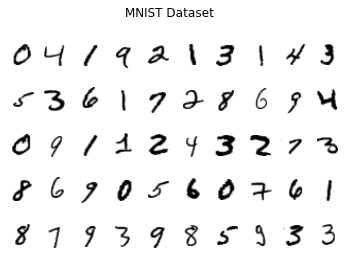

In [17]:
fig = plt.figure()
for index in  range(1, ROW_IMG * N_ROWS + 1):
  plt.subplot(N_ROWS, ROW_IMG, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset')

10:29:29 ---- Epoch: 0	Train Loss: 0.2300	Valid Loss: 0.0898	Train Accuracy: 97.33	Valid Accuracy: 97.27
10:30:19 ---- Epoch: 1	Train Loss: 0.0789	Valid Loss: 0.0808	Train Accuracy: 97.85	Valid Accuracy: 97.59
10:31:07 ---- Epoch: 2	Train Loss: 0.0555	Valid Loss: 0.0553	Train Accuracy: 98.60	Valid Accuracy: 98.28
10:31:56 ---- Epoch: 3	Train Loss: 0.0444	Valid Loss: 0.0491	Train Accuracy: 98.93	Valid Accuracy: 98.47
10:32:44 ---- Epoch: 4	Train Loss: 0.0348	Valid Loss: 0.0465	Train Accuracy: 99.21	Valid Accuracy: 98.54
10:33:32 ---- Epoch: 5	Train Loss: 0.0297	Valid Loss: 0.0435	Train Accuracy: 99.25	Valid Accuracy: 98.70
10:34:20 ---- Epoch: 6	Train Loss: 0.0260	Valid Loss: 0.0434	Train Accuracy: 99.50	Valid Accuracy: 98.74
10:35:07 ---- Epoch: 7	Train Loss: 0.0213	Valid Loss: 0.0478	Train Accuracy: 99.39	Valid Accuracy: 98.55
10:35:56 ---- Epoch: 8	Train Loss: 0.0198	Valid Loss: 0.0423	Train Accuracy: 99.59	Valid Accuracy: 98.78
10:36:44 ---- Epoch: 9	Train Loss: 0.0170	Valid Loss: 0

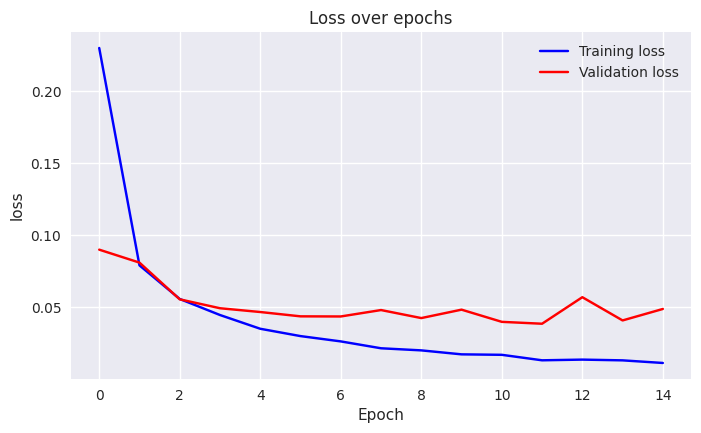

In [22]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)



Text(0.5, 0.98, 'LENET5 Predictions')

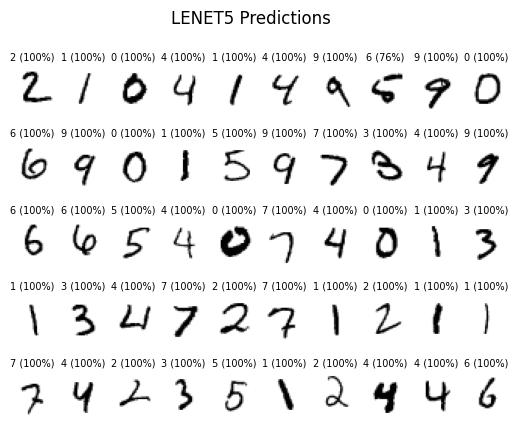

In [24]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
  plt.subplot(N_ROWS, ROW_IMG, index)
  plt.axis('off')
  plt.imshow(valid_dataset.data[index], cmap='gray_r')

  with torch.no_grad():
    model.eval()
    _, probs = model(valid_dataset[index][0].unsqueeze(0))

  title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'

  plt.title(title, fontsize=7)
fig.suptitle('LENET5 Predictions')